/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading and preparing data...
Successfully loaded df_weather2.csv.
Data aggregated to daily level:


,Site,net_qty,OrderQty,CanceledQty,MenuPrice,MenuSubsidy,tavg_C,prcp_mm,rain_flag,temp_dev,is_holiday,is_weekend,MenuBase,SchoolID,hist_cancel_rate,daily_cancel_pct
DateOfService,,,,,,,,,,,,,,,,
2020-01-02,BK,32,32,0,1.812500,1.687500,1.2,0.0,0,-2.957672,0,0,1,1,0.979676,0.0
2020-01-02,LP,169,169,0,2.832530,0.240964,0.3,0.0,0,-3.965782,1,1,1,2,1.049900,0.0
2020-01-03,BK,32,32,0,1.993750,1.506250,6.8,201.6,1,2.642328,0,0,1,1,0.979676,0.0
2020-01-03,LP,184,184,0,2.714088,0.334530,6.7,886.9,1,2.434218,1,1,1,2,1.049900,0.0
2020-01-04,LP,1,1,0,0.000000,3.500000,4.7,5.1,1,0.434218,0,0,1,1,1.049900,0.0



========================= Processing Site: BK =========================
Evaluating model with cross-validation...
Results -> Asymmetric Loss: 371.05 (+/- 159.99) | RMSE: 502.96 (+/- 258.76) meals
Fitting final pipeline for visualization...
Generating SHAP summary plot...


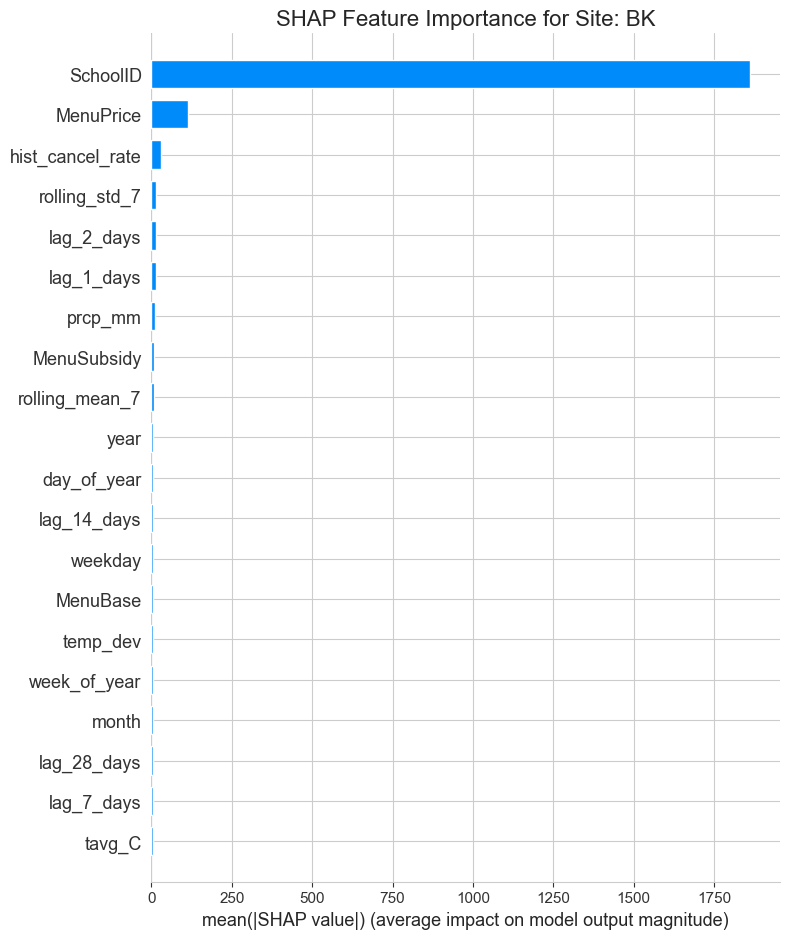

Generating Actual vs. Predicted plot...


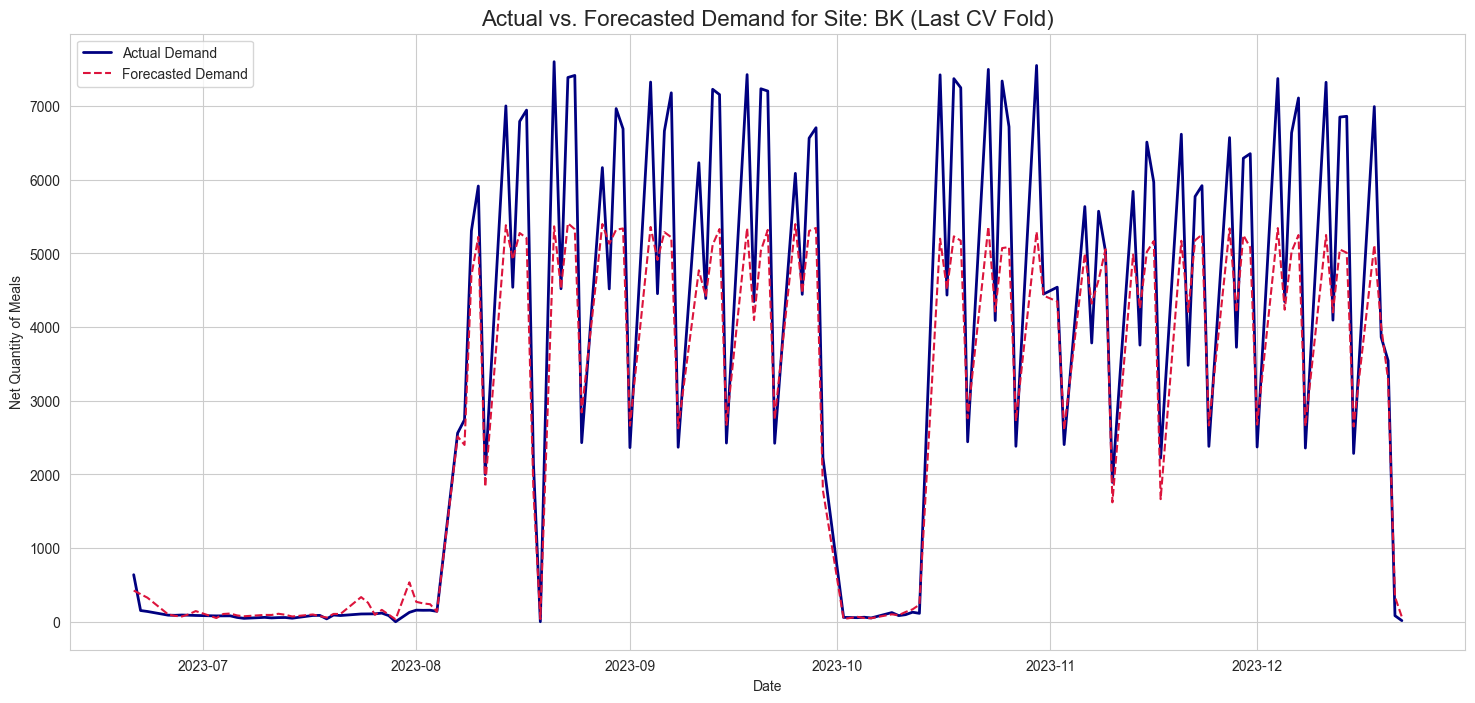

Generating Residuals plot...


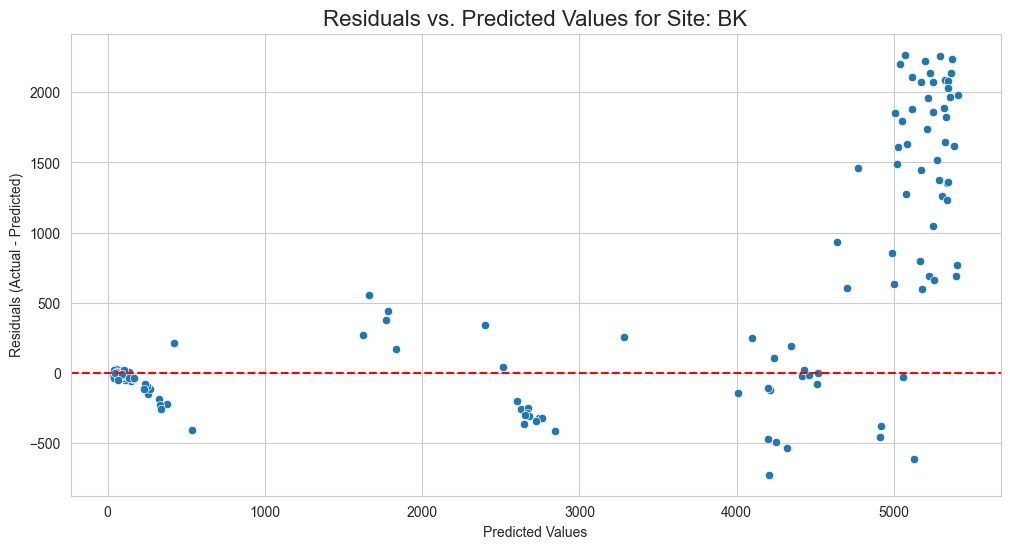


========================= Processing Site: LP =========================
Evaluating model with cross-validation...
Results -> Asymmetric Loss: 483.72 (+/- 175.32) | RMSE: 611.54 (+/- 125.13) meals
Fitting final pipeline for visualization...
Generating SHAP summary plot...


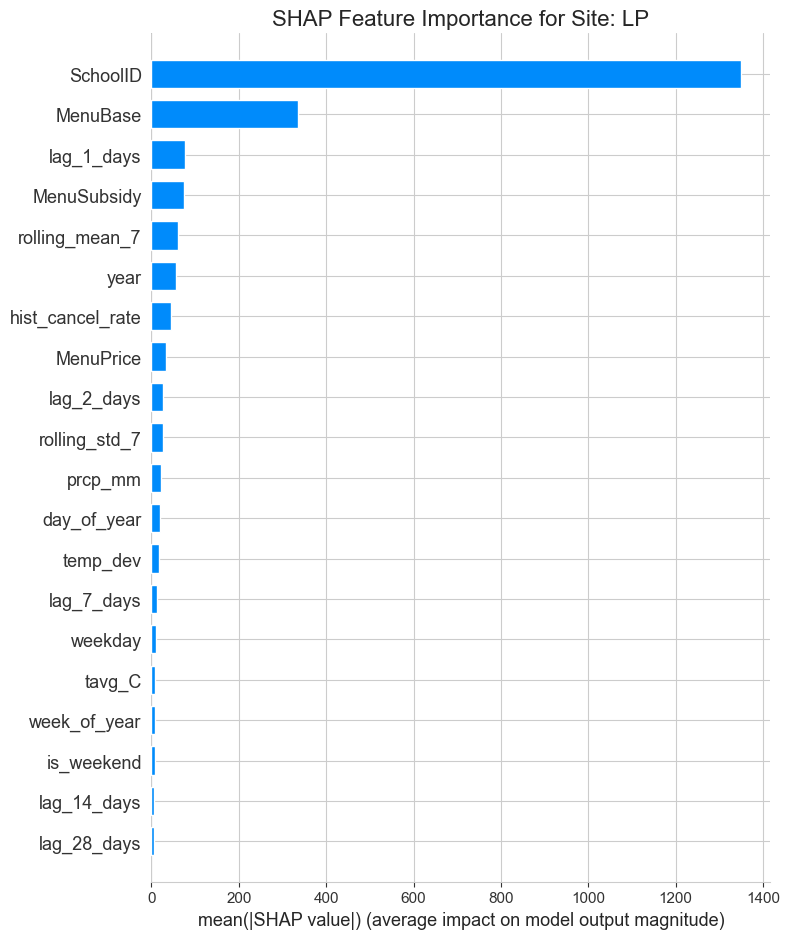

Generating Actual vs. Predicted plot...


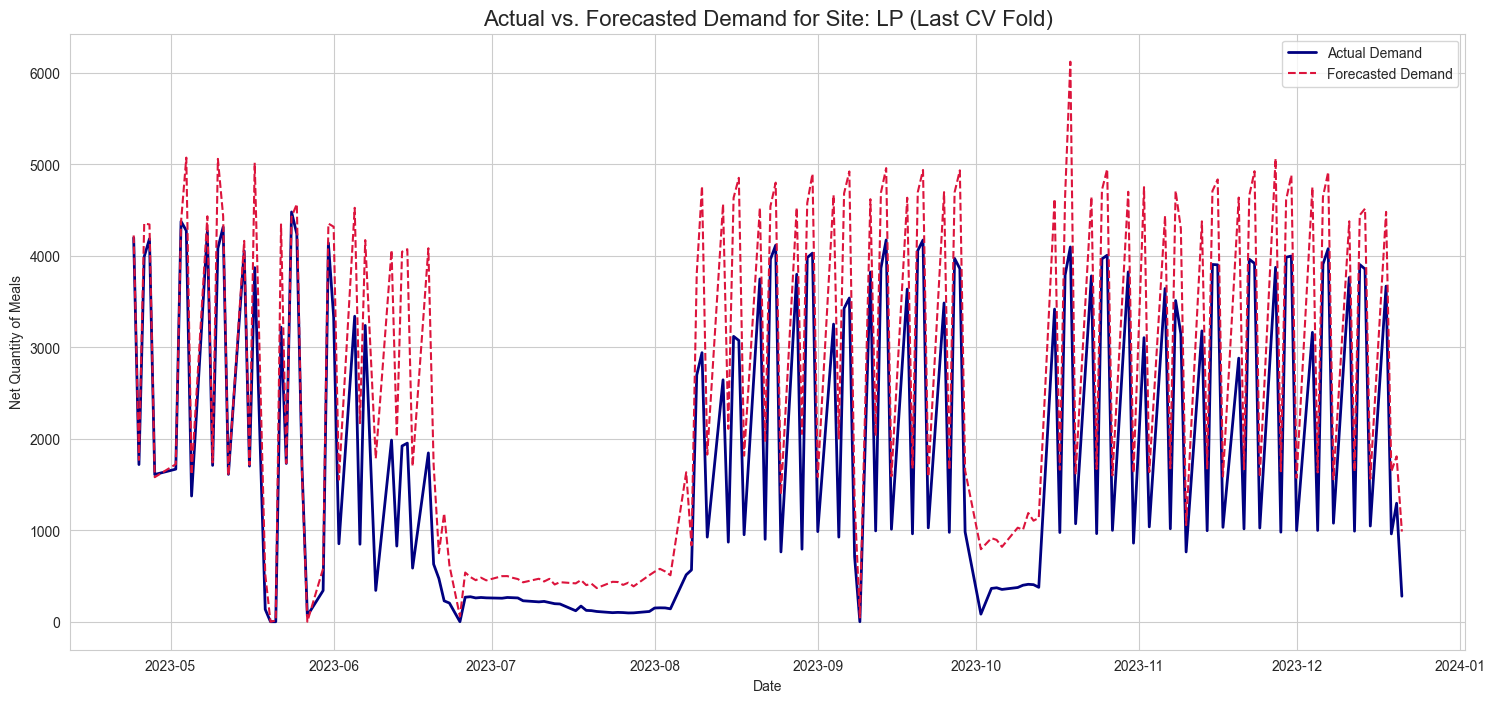

Generating Residuals plot...


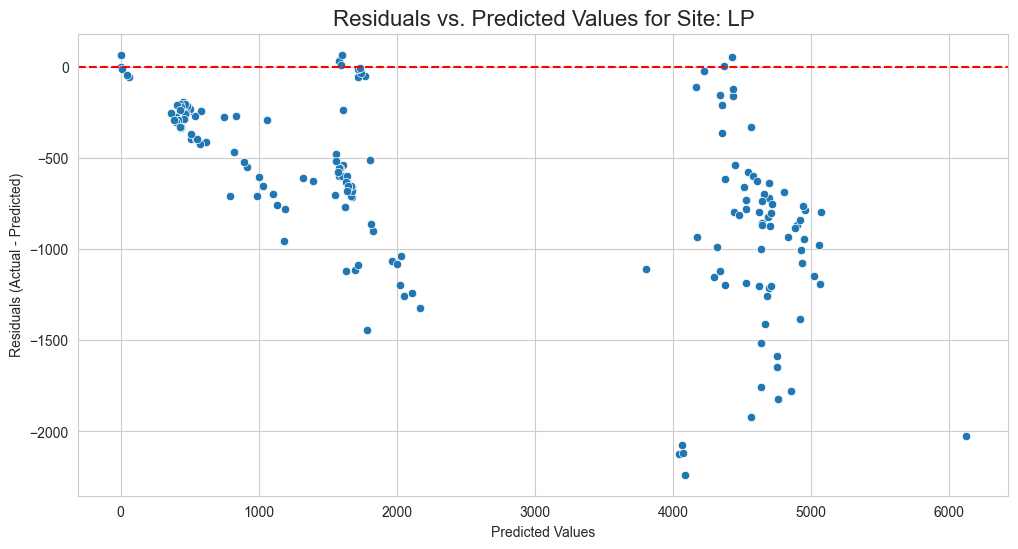


========================= Processing Site: MS =========================
Evaluating model with cross-validation...
Results -> Asymmetric Loss: 306.05 (+/- 369.39) | RMSE: 371.47 (+/- 462.58) meals
Fitting final pipeline for visualization...
Generating SHAP summary plot...


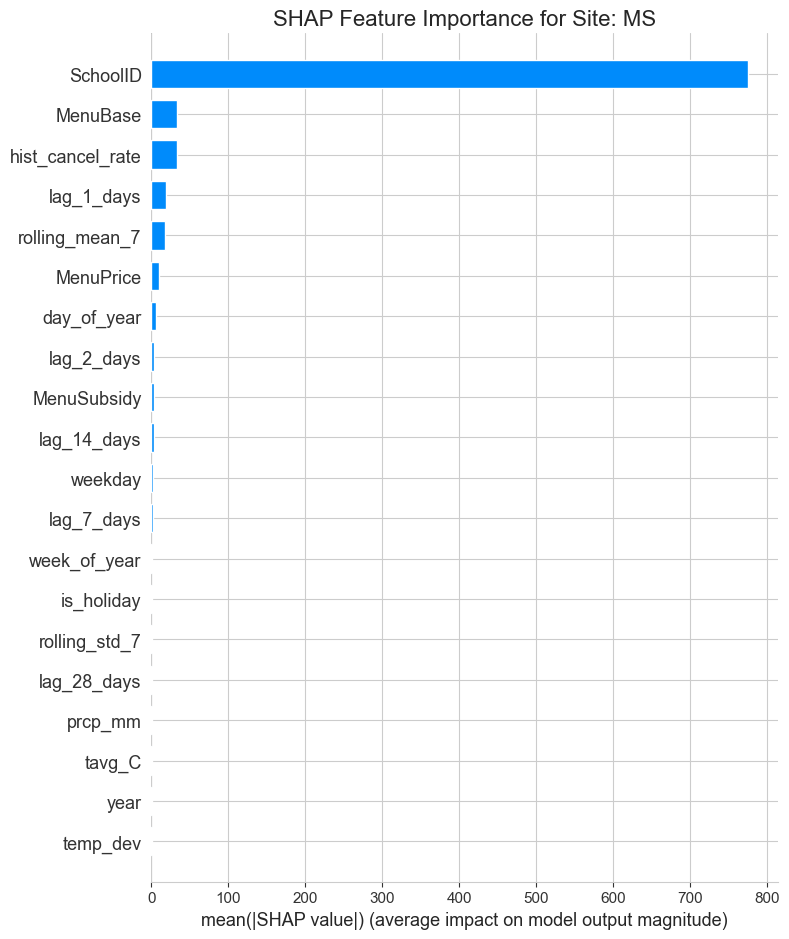

Generating Actual vs. Predicted plot...


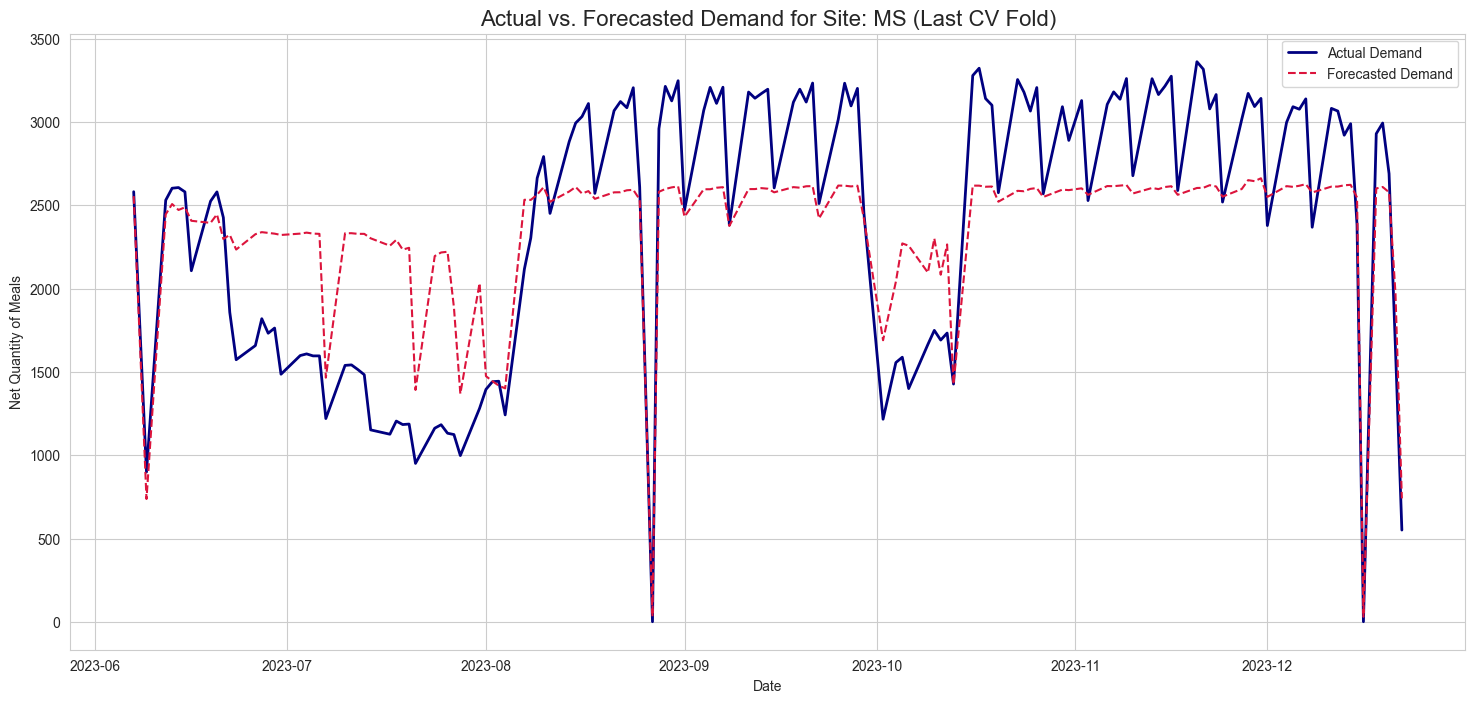

Generating Residuals plot...


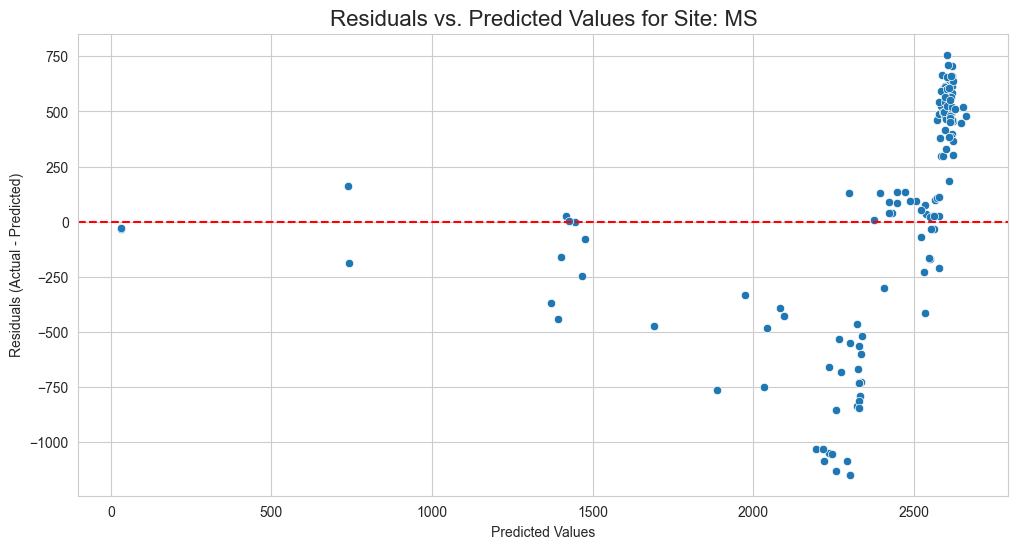


========================= FINAL MODEL PERFORMANCE SUMMARY =========================


,Asymmetric Loss,RMSE
BK,371.05 (+/- 159.99),502.96 (+/- 258.76)
LP,483.72 (+/- 175.32),611.54 (+/- 125.13)
MS,306.05 (+/- 369.39),371.47 (+/- 462.58)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
import shap

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')
# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

# =============================================================================
# 1. DATA LOADING AND PRE-AGGREGATION
# =============================================================================
print("Loading and preparing data...")
try:
    df = pd.read_csv('/Users/shayan/Desktop/IDS2/Stattkueche/df_weather2.csv', parse_dates=['DateOfService', 'DateOfOrder'])
    print("Successfully loaded df_weather2.csv.")
except FileNotFoundError:
    print("FATAL ERROR: df_weather2.csv not found. Please update the file path.")
    exit()

df['net_qty'] = df['OrderQty'] - df['CanceledQty']

# =============================================================================
# 2. DAILY AGGREGATION
# =============================================================================
# We aggregate the data to the daily level, which is the target for our forecast.
agg_dict = {
    'net_qty': 'sum',
    'OrderQty': 'sum',
    'CanceledQty': 'sum',
    'MenuPrice': 'mean',
    'MenuSubsidy': 'mean',
    'tavg_C': 'mean',
    'prcp_mm': 'sum',
    'rain_flag': 'max',
    'temp_dev': 'mean',
    'is_holiday': 'max',
    'is_weekend': 'max',
    'MenuBase': 'nunique',
    'SchoolID': 'nunique',
    'hist_cancel_rate': 'mean'
}
df_daily = df.groupby(['DateOfService', 'Site']).agg(agg_dict).reset_index()
df_daily['daily_cancel_pct'] = (df_daily['CanceledQty'] / df_daily['OrderQty']).fillna(0)
df_daily = df_daily.sort_values('DateOfService').set_index('DateOfService')

print("Data aggregated to daily level:")
display(df_daily.head())


# =============================================================================
# 3. CUSTOM TRANSFORMERS (ADAPTED FROM YOUR ORIGINAL CODE)
# =============================================================================
# Your powerful transformers are preserved here. They will be used in the pipeline.
# Note: These now operate on the daily aggregated data.

class DailyFeatureEngineer(BaseEstimator, TransformerMixin):
    """Creates time-based and lag features for the daily data."""
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['day_of_year'] = X_copy.index.dayofyear
        X_copy['weekday'] = X_copy.index.weekday
        X_copy['month'] = X_copy.index.month
        X_copy['year'] = X_copy.index.year
        X_copy['week_of_year'] = X_copy.index.isocalendar().week.astype(int)
        X_copy['quarter'] = X_copy.index.quarter

        for lag in [1, 2, 7, 14, 28]:
            X_copy[f'lag_{lag}_days'] = X_copy.groupby('Site')['net_qty'].shift(lag)

        X_copy['rolling_mean_7'] = X_copy.groupby('Site')['net_qty'].shift(1).rolling(window=7, min_periods=1).mean()
        X_copy['rolling_std_7'] = X_copy.groupby('Site')['net_qty'].shift(1).rolling(window=7, min_periods=1).std()
        return X_copy

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.cols_to_drop, errors='ignore')

class MissingImputer(BaseEstimator, TransformerMixin):
    """Imputes missing values and drops rows if any NaNs remain after."""
    def __init__(self, strategy='median'):
        self.strategy = strategy
    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(include=np.number).columns
        self.imputer_ = SimpleImputer(strategy=self.strategy)
        self.imputer_.fit(X[self.num_cols])
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.num_cols] = self.imputer_.transform(X_copy[self.num_cols])
        # Drop any rows that might still have NaNs (e.g., from initial lags)
        X_copy.dropna(inplace=True)
        return X_copy

# =============================================================================
# 4. CUSTOM SCORER & PIPELINE DEFINITION
# =============================================================================
def asymmetric_loss(y_true, y_pred, under_penalty=1.2):
    error = y_true - y_pred
    loss = np.mean(np.where(error < 0, -error * under_penalty, error))
    return loss

asymmetric_scorer = make_scorer(asymmetric_loss, greater_is_better=False)

# Define the columns to be dropped before modeling
# We exclude the target, its components, and the site identifier
features_to_exclude = ['net_qty', 'Site', 'OrderQty', 'CanceledQty', 'daily_cancel_pct']

# This is the full pipeline, incorporating your logic in a regression context
pipeline = Pipeline([
    ('daily_features', DailyFeatureEngineer()),
    ('imputer', MissingImputer()), # Impute NaNs from lags/rolling features
    ('dropper', ColumnDropper(cols_to_drop=features_to_exclude)),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# =============================================================================
# 5. MODEL TRAINING, EVALUATION, AND VISUALIZATION
# =============================================================================
sites = df_daily['Site'].unique()
all_scores = {}
fitted_pipelines = {}

for site in sites:
    print(f"\n{'='*25} Processing Site: {site} {'='*25}")

    # Prepare data for the current site
    df_site = df_daily[df_daily['Site'] == site].copy()

    # The pipeline will handle feature creation and dropping internally
    X = df_site
    y = df_site['net_qty']

    if len(X) < 100: # Increased threshold for robust CV
        print(f"Skipping site {site} due to insufficient data.")
        continue

    tscv = TimeSeriesSplit(n_splits=5)

    # --- Evaluate Model ---
    print("Evaluating model with cross-validation...")
    custom_scores = -cross_val_score(pipeline, X, y, cv=tscv, scoring=asymmetric_scorer, n_jobs=-1)
    rmse_scores = -cross_val_score(pipeline, X, y, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)

    all_scores[site] = {
        'Asymmetric Loss': f"{custom_scores.mean():.2f} (+/- {custom_scores.std():.2f})",
        'RMSE': f"{rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})"
    }
    print(f"Results -> Asymmetric Loss: {all_scores[site]['Asymmetric Loss']} | RMSE: {all_scores[site]['RMSE']} meals")

    # --- Fit final pipeline on all data for this site for visualization ---
    print("Fitting final pipeline for visualization...")
    final_pipeline = pipeline.fit(X, y)
    fitted_pipelines[site] = final_pipeline

    # Extract the transformed data and fitted model for SHAP
    X_transformed = final_pipeline.named_steps['dropper'].transform(
        final_pipeline.named_steps['imputer'].transform(
            final_pipeline.named_steps['daily_features'].transform(X)
        )
    )
    regressor = final_pipeline.named_steps['regressor']

    # Plot 1: SHAP Summary Plot (Advanced Feature Importance)
    print("Generating SHAP summary plot...")
    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(X_transformed)
    plt.title(f'SHAP Feature Importance for Site: {site}', fontsize=16)
    shap.summary_plot(shap_values, X_transformed, plot_type="bar", show=False)
    plt.show()

    # Plot 2: Actual vs. Predicted for the last CV fold
    print("Generating Actual vs. Predicted plot...")
    train_indices, test_indices = list(tscv.split(X))[-1]
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    vis_pipeline = pipeline.fit(X_train, y_train)
    predictions = vis_pipeline.predict(X_test)

    plt.figure(figsize=(18, 8))
    plt.plot(y_test.index, y_test, label='Actual Demand', color='navy', lw=2)
    plt.plot(y_test.index, predictions, label='Forecasted Demand', color='crimson', linestyle='--')
    plt.title(f'Actual vs. Forecasted Demand for Site: {site} (Last CV Fold)', fontsize=16)
    plt.ylabel('Net Quantity of Meals')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

    # Plot 3: Residuals Plot
    print("Generating Residuals plot...")
    residuals = y_test - predictions
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=predictions, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals vs. Predicted Values for Site: {site}', fontsize=16)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.show()


# =============================================================================
# 6. FINAL SUMMARY
# =============================================================================
print(f"\n{'='*25} FINAL MODEL PERFORMANCE SUMMARY {'='*25}")
summary_df = pd.DataFrame(all_scores).T
display(summary_df)
